In [ ]:
# pip install praw

In [ ]:
# pip install pmaw

In [ ]:
#### Required Libraries
### API libraries
import praw
from pmaw import PushshiftAPI
import datetime
import time

### General Libraries
import warnings
warnings.filterwarnings("always")
import pandas as pd
import numpy as np
from pprint import pprint
from itertools import chain


# sentiment analysis
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize, RegexpTokenizer # tokenize words
from nltk.corpus import stopwords

# visualization
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10, 8) # default plot size
import seaborn as sns
sns.set(style='whitegrid', palette='Dark2')
from wordcloud import WordCloud

In [ ]:
# initialize PRAW with your Reddit API credentials

reddit = praw.Reddit(client_id='reAPy5z2pXenVRy5wjxUzQ',
                     client_secret='runTXR51hPwEHF2lg2-DoKKqqAdt-g',
                     username='',
                     password='',
                     user_agent='Research')

# initialize PMAW with a PushshiftAPI object
api = PushshiftAPI()

# specify the subreddit you want to scrape
subreddit = 'AntiVaxxers'

# specify the datetime range you want to scrape
start_date = int(datetime.datetime(2021, 1, 1).timestamp())
end_date = int(datetime.datetime(2021, 12, 1).timestamp())

filters = ['id', 'author', 'created_utc',
                   'domain', 'url',
                   'title', 'num_comments','score']



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
# sleep_time  = 2
# ## max loop count is necessary instead of true ( so that loop breaks)
# while True:
#     try:
#         submissions = api.search_submissions(subreddit=subreddit,
#                                           after=start_date,
#                                           before=end_date,
#                                           filter=filters)
        
#         df = pd.DataFrame(list(submissions))
#         if len(df) > 0:
#             # df = pd.DataFrame(list(submissions))
#             df.to_excel('AntiVaxxers_January2021.xlsx', index=False)
#             print("Data saved to Excel file.")
#             break
#         else:
#             print("No data found, retrying...")
#             time.sleep(sleep_time)
#             continue
#     except Warning as w:
#         print(w)
#         time.sleep(sleep_time)
#         continue

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
sleep_time = 2
max_attempts = 10
attempt_count = 0

while attempt_count < max_attempts:
    try:
        submissions = api.search_submissions(subreddit=subreddit,
                                              after=start_date,
                                              before=end_date,
                                              filter=filters)

        df = pd.DataFrame(list(submissions))
        if len(df) > 0:
            df.to_excel('AntiVaxxers_January2021.xlsx', index=False)
            print("Data saved to Excel file.")
            break
        else:
            print("No data found, retrying...")
            time.sleep(sleep_time)
            attempt_count += 1
            continue
    except Warning as w:
        print(w)
        time.sleep(sleep_time)
        attempt_count += 1
        continue
        
if attempt_count == max_attempts:
    print("Max attempts reached, exiting loop.")

In [ ]:
# ignore the warnings that are not important.
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df.head(5)

,author,created_utc,domain,id,num_comments,score,title,url
0,[deleted],1638312826,i.redd.it,r5zsc6,6,0,Yes!!!,https://i.redd.it/wy5wmjcnbt281.jpg
1,Taylorm-psd,1638312075,i.redd.it,r5zit5,1,1,I made an illustration based on some hypocrisy...,https://i.redd.it/ccpl6ui49t281.jpg
2,youaremoree,1638309664,youtu.be,r5yn1c,1,1,"subscribe and like, please! I have more to share",https://youtu.be/efiZUDsqlro
3,[deleted],1638292497,twitter.com,r5s3uc,143,45,Bernie sub got overrun by anti vaxxers,https://twitter.com/BernieSanders/status/14443...
4,ThePlatypusCA,1638280478,theplatypus.ca,r5nru9,1,1,Loser Chris “Sky” Saccoccia Plans on Protestin...,https://www.theplatypus.ca/2021/11/loser-chris...


In [ ]:
df['created_utc'] = df['created_utc'].apply(lambda x: datetime.datetime.fromtimestamp(x))


In [ ]:
df.shape

(4476, 8)

### Sentiment Analysis - Vader

Sentiment Intensity Analyzer is a lexicon-based approach to sentiment analysis, which means it uses a pre-defined set of words and phrases with assigned polarity (positive, negative, or neutral) to determine the sentiment of a given text. It works by assigning a score to each word or phrase in a text based on its polarity, and then computing an overall score for the text based on the sum of the scores of its individual words and phrases.

The polarity scores of Sentiment Intensity Analyzer represent the degree of positive or negative sentiment in a given text. The scores range from -1 to 1, where -1 indicates extremely negative sentiment, 0 indicates neutral sentiment, and 1 indicates extremely positive sentiment. The closer the score is to -1 or 1, the stronger the sentiment expressed in the text.

For example, the phrase "I love this movie" would have a high positive score, while the phrase "I hate this movie" would have a high negative score. The polarity scores can be used to compare the sentiment of different texts or to track changes in sentiment over time.

After analyzing a text with Sentiment Intensity Analyzer, it produces a compound score that represents an overall sentiment of the text. The compound score is a single value that ranges between -1 and 1, where -1 indicates extremely negative sentiment and 1 indicates extremely positive sentiment.

The compound score is calculated as a sum of all the valence scores of individual words in the text, normalized between -1 (most extreme negative) and +1 (most extreme positive). It takes into account both the polarity of individual words and the context in which they appear.

A compound score of 0 indicates a neutral sentiment, while scores above 0 indicate positive sentiment and scores below 0 indicate negative sentiment. The magnitude of the compound score indicates the overall strength of the sentiment, with larger scores indicating stronger sentiment.

In summary, the compound score produced by Sentiment Intensity Analyzer represents an overall sentiment of a text, taking into account both the polarity of individual words and the context in which they appear.


In [ ]:
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

sia = SentimentIntensityAnalyzer()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
res = [*df['title'].apply(sia.polarity_scores)]
pprint(res[:3])

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[{'compound': 0.5538, 'neg': 0.0, 'neu': 0.0, 'pos': 1.0},
 {'compound': 0.0, 'neg': 0.0, 'neu': 1.0, 'pos': 0.0},
 {'compound': 0.7629, 'neg': 0.0, 'neu': 0.398, 'pos': 0.602}]


In [ ]:
sentiment_df = pd.DataFrame.from_records(res)
df_merged = pd.concat([df, sentiment_df], axis=1, join='inner')
df_merged.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,created_utc,domain,id,num_comments,score,title,url,neg,neu,pos,compound
0,[deleted],1638312826,i.redd.it,r5zsc6,6,0,Yes!!!,https://i.redd.it/wy5wmjcnbt281.jpg,0.000,0.000,1.000,0.5538
1,Taylorm-psd,1638312075,i.redd.it,r5zit5,1,1,I made an illustration based on some hypocrisy...,https://i.redd.it/ccpl6ui49t281.jpg,0.000,1.000,0.000,0.0000
2,youaremoree,1638309664,youtu.be,r5yn1c,1,1,"subscribe and like, please! I have more to share",https://youtu.be/efiZUDsqlro,0.000,0.398,0.602,0.7629
3,[deleted],1638292497,twitter.com,r5s3uc,143,45,Bernie sub got overrun by anti vaxxers,https://twitter.com/BernieSanders/status/14443...,0.277,0.723,0.000,-0.3182
4,ThePlatypusCA,1638280478,theplatypus.ca,r5nru9,1,1,Loser Chris “Sky” Saccoccia Plans on Protestin...,https://www.theplatypus.ca/2021/11/loser-chris...,0.341,0.659,0.000,-0.8316


The THRESHOLD variable is set to a value of 0.2, which is used as a threshold for determining the sentiment of the text. The conditions list contains three conditions:

    The first condition checks if the compound score is less than or equal to -0.2, which is considered as negative sentiment.
    The second condition checks if the compound score is greater than -0.2 and less than 0.2, which is considered as neutral sentiment.
    The third condition checks if the compound score is greater than or equal to 0.2, which is considered as positive sentiment.

The values list contains three corresponding labels for the three conditions: "neg" for negative sentiment, "neu" for neutral sentiment, and "pos" for positive sentiment.

The np.select() function takes the conditions and values lists as input and returns a new column called label, which contains the corresponding sentiment labels based on the compound scores. Finally, df_merged.head() is used to display the first few rows of the updated DataFrame with the new label column.

Choosing the appropriate threshold value for sentiment analysis can depend on various factors, such as the type of text being analyzed, the goals of the analysis, and the desired balance between precision and recall.

A threshold value that is too low may result in a high number of false positives, where neutral or slightly positive/negative texts are misclassified as strongly positive/negative. A threshold value that is too high may result in a high number of false negatives, where strongly positive/negative texts are misclassified as neutral or slightly positive/negative.

One common approach to choosing the threshold value is to use a trial-and-error method, where you test the performance of the sentiment analysis model with different threshold values on a validation set of data. You can evaluate the performance of the model using metrics such as accuracy, precision, recall, and F1 score. You can choose the threshold value that gives the best overall performance on the validation set.

Alternatively, you can use a pre-defined threshold value that is appropriate for your specific use case or domain. For example, a threshold value of 0.2 may be appropriate for sentiment analysis of social media posts, while a threshold value of 0.5 may be appropriate for sentiment analysis of product reviews.

In [ ]:
#### initialising threshold
THRESHOLD = 0.2

conditions = [
    (df_merged['compound'] <= -THRESHOLD),
    (df_merged['compound'] > -THRESHOLD) & (df_merged['compound'] < THRESHOLD),
    (df_merged['compound'] >= THRESHOLD),
    ]

values = ["neg", "neu", "pos"]
df_merged['label'] = np.select(conditions, values)

df_merged.head()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,author,created_utc,domain,id,num_comments,score,title,url,neg,neu,pos,compound,label
0,[deleted],1638312826,i.redd.it,r5zsc6,6,0,Yes!!!,https://i.redd.it/wy5wmjcnbt281.jpg,0.000,0.000,1.000,0.5538,pos
1,Taylorm-psd,1638312075,i.redd.it,r5zit5,1,1,I made an illustration based on some hypocrisy...,https://i.redd.it/ccpl6ui49t281.jpg,0.000,1.000,0.000,0.0000,neu
2,youaremoree,1638309664,youtu.be,r5yn1c,1,1,"subscribe and like, please! I have more to share",https://youtu.be/efiZUDsqlro,0.000,0.398,0.602,0.7629,pos
3,[deleted],1638292497,twitter.com,r5s3uc,143,45,Bernie sub got overrun by anti vaxxers,https://twitter.com/BernieSanders/status/14443...,0.277,0.723,0.000,-0.3182,neg
4,ThePlatypusCA,1638280478,theplatypus.ca,r5nru9,1,1,Loser Chris “Sky” Saccoccia Plans on Protestin...,https://www.theplatypus.ca/2021/11/loser-chris...,0.341,0.659,0.000,-0.8316,neg


### Vader on individual words

In [ ]:
sentence0 = df_merged.title.iloc[0]
print(sentence0)
words0 = df_merged.title.iloc[0].split()
print(words0)

pos_list, neg_list, neu_list = [], [], []

for word in words0:
  if (sia.polarity_scores(word)['compound']) >= THRESHOLD:
    pos_list.append(word)
  elif (sia.polarity_scores(word)['compound']) <= -THRESHOLD:
    neg_list.append(word)
  else:
    neu_list.append(word)                

print('\nPositive:',pos_list)        
print('Neutral:',neu_list)    
print('Negative:',neg_list) 
score = sia.polarity_scores(sentence0)

print(f"\nThis sentence is {round(score['neg'] * 100, 2)}% negative")
print(f"This sentence is {round(score['neu'] * 100, 2)}% neutral")
print(f"This sentence is {round(score['pos'] * 100, 2)}% positive")
print(f"The compound value : {score['compound']} <= {-THRESHOLD}")


# source https://stackoverflow.com/a/51515048/11386747

Yes!!!
['Yes!!!']

Positive: ['Yes!!!']
Neutral: []
Negative: []

This sentence is 0.0% negative
This sentence is 0.0% neutral
This sentence is 100.0% positive
The compound value : 0.5538 <= -0.2


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
df_merged.label.value_counts()

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


neu    2375
pos    1075
neg    1026
Name: label, dtype: int64

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<Axes: xlabel='label', ylabel='Count'>

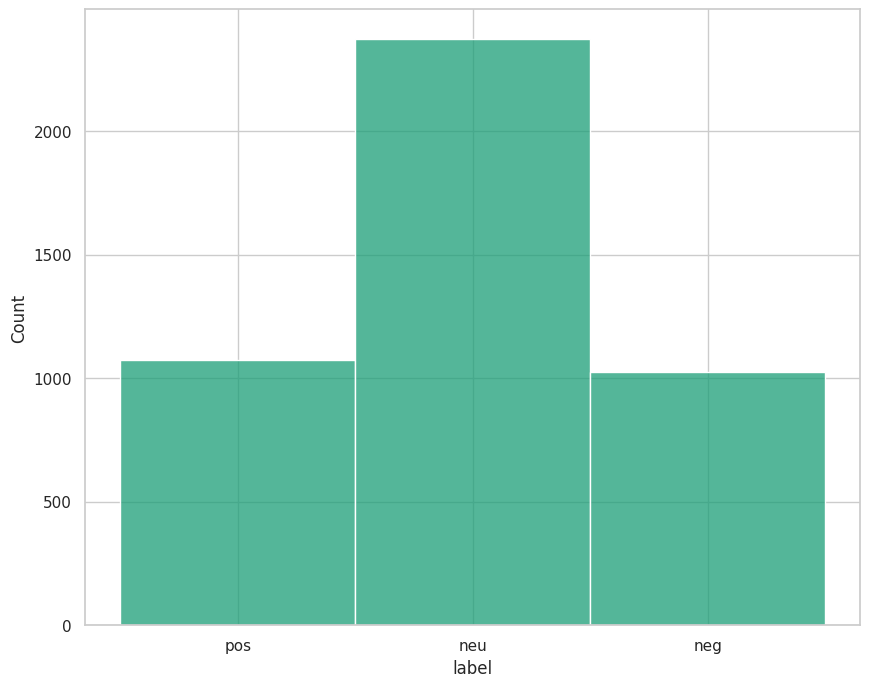

In [ ]:
sns.histplot(df_merged.label)

#### Sample posts based on labels

In [ ]:
def title_output(df, label):
    res = df[df['label'] == label].title.values
    print(f'{"=" * 20}')
    print("\n".join(title for title in res))

# randomly sample
df_sub = df_merged.groupby('label').sample(n = 5, random_state = 7)

print("Positive news")
title_output(df_sub, "pos")

print("\nNeutral news")
title_output(df_sub, "neu")

print("\nNegative news")
title_output(df_sub, "neg")

Positive news
Fun Update to the Austria Vaccine Mandate
subscribe and like, please! I have more to share
Yes
Antivaxx Super Saiyan modes during an argument
Claims that Covid has a 99.7% survival rate. Clearly doesn't give a shit about all the people who have died from it or their families. Fucking piece of shit.

Neutral news
I do my own research and listen to professionals who say it’s gonna take til 2076.
If Xi variant is confirmed in so many other counties, why is Africa the sole focus?! Hmm🤔
[deleted by user]
If Xi variant is confirmed in so many other counties, why is Africa the sole focus?! Hmm🤔
thoughts

Negative news
If YOU refuse to get vaccinated, you deserve to be excluded from venues and events.
I want to argue
Covid-19 Vaccine Hesitancy Survey
I don't even need to sort by controversial to know what's there
Loser Chris “Sky” Saccoccia Plans on Protesting West Edmonton Mall, Threatens To Zip Tie Anyone Who Gets in His Way


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Tokenizing

Tokenization is the process of breaking down a text into smaller units called tokens. In natural language processing, these tokens are typically words, but they can also be other units such as punctuation marks, numbers, or special characters. Tokenization is a fundamental step in many NLP tasks, such as text classification, information retrieval, and machine translation.

The tokenization process involves several steps. First, the text is segmented into sentences, if necessary. Then, each sentence is further divided into individual words or tokens, which are separated by white spaces or other delimiters. In some cases, the tokens may also be normalized or transformed, such as converting all words to lowercase or replacing contractions with their expanded forms.

Tokenization can be performed using various methods, including rule-based approaches and machine learning algorithms. Some common tokenization tools in NLP include NLTK (Natural Language Toolkit), spaCy, and Stanford CoreNLP. The choice of tokenization method can depend on the specific task and the properties of the text being analyzed.



Stop words are common words that are frequently used in a language but do not carry much meaning and are usually removed from text when performing natural language processing tasks. In the context of the English language, examples of stop words include "the," "and," "of," "to," "in," "that," "is," and "it."

The NLTK (Natural Language Toolkit) is a popular Python library for working with natural language processing. It provides a pre-defined set of stop words for several languages, including English. 

In [ ]:
stop_words = stopwords.words('english')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def custom_tokenize(text):
  # remove single quote and dashes
  text = text.replace("'", "").replace("-", "").lower()

  # split on words only
  tk = nltk.tokenize.RegexpTokenizer(r'\w+')
  tokens = tk.tokenize(text)

  # remove stop words
  words = [w for w in tokens if not w in stop_words]
  return words

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def tokens_title(df, label):
  # subset titles based on label
  titles = df[df['label'] == label].title
  # apply our custom tokenize function to each title
  tokens = titles.apply(custom_tokenize)
  # join nested lists into a single list
  words = list(chain.from_iterable(tokens))
  return words



/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pos_words = tokens_title(df_merged, 'pos')
neg_words = tokens_title(df_merged, 'neg')

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
pos_freq = nltk.FreqDist(pos_words)
pos_freq.most_common(20)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('covid', 180),
 ('yes', 135),
 ('antivax', 135),
 ('im', 135),
 ('like', 90),
 ('proud', 90),
 ('got', 90),
 ('full', 90),
 ('hospital', 90),
 ('7', 90),
 ('shit', 90),
 ('canada', 90),
 ('give', 89),
 ('fun', 88),
 ('subscribe', 45),
 ('please', 45),
 ('share', 45),
 ('auntie', 45),
 ('vaxxer', 45),
 ('holiday', 45)]

In [ ]:
neg_freq = nltk.FreqDist(neg_words)
neg_freq.most_common(20)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('anti', 313),
 ('vaccine', 221),
 ('hesitancy', 176),
 ('vax', 135),
 ('vaxxers', 90),
 ('getting', 90),
 ('tech', 90),
 ('sad', 90),
 ('grift', 90),
 ('mask', 90),
 ('useless', 90),
 ('joe', 90),
 ('biden', 90),
 ('covid', 89),
 ('want', 89),
 ('know', 89),
 ('vaccines', 88),
 ('covid19', 88),
 ('survey', 88),
 ('vaxxer', 88)]

### Word Clouds

A word cloud is a visualization technique that represents a text as a collection of words, where the size of each word corresponds to its frequency or importance in the text. Word clouds are often used to provide a quick overview of the most prominent topics or themes in a large text corpus.

To create a word cloud, the text is first processed to remove stop words (common words that are not informative, such as "the" and "and"), punctuation, and other noise. Then, each remaining word is assigned a weight based on its frequency or some other measure of importance, such as TF-IDF (term frequency-inverse document frequency).

Once the words and weights have been determined, they are plotted in a visual representation, typically using a cloud-like shape, where the size of each word corresponds to its weight. The words are usually arranged randomly or in a way that maximizes their visibility and readability.

Word clouds can be useful for gaining a quick understanding of the most prominent themes or topics in a text corpus, as well as for identifying outliers or unusual patterns. However, they have some limitations, such as the lack of context and the potential for misinterpreting the importance of individual words. Therefore, word clouds are often used in combination with other visualization and analysis techniques.

The WordCloud class from the wordcloud library in Python is used to generate word clouds from text data. A word cloud is a graphical representation of the most frequently occurring words in a text corpus, where the size of each word in the cloud is proportional to its frequency

In [ ]:
def plot_word_cloud(words, colormap, stopwords = [], max_words = 100):
  text = " ".join(word for word in words)
  # generate word cloud 
  wordcloud = WordCloud(width=1000, height = 600,
                        max_words = max_words,
                        colormap=colormap,
                        stopwords = stopwords,
                        background_color="black").generate(text)

  # Display the generated image:
  plt.figure( figsize=(20,10), facecolor='k' )
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.axis("off");

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


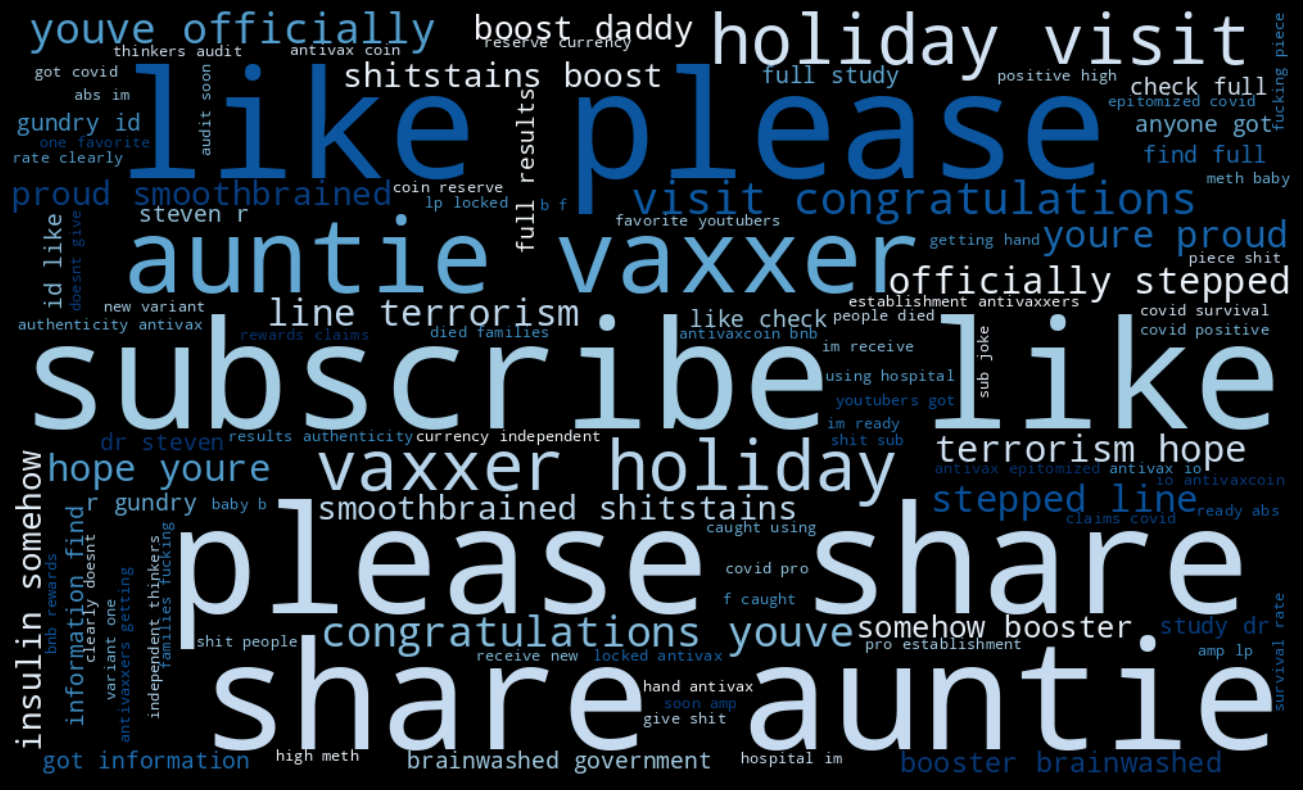

In [ ]:
custom_stopwords = ["haha", "yes", "lmao", "felt"]
plot_word_cloud(pos_words, "Blues", custom_stopwords)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.9/dist-packages/wordcloud/wordcloud.py:106: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.colormap = plt.cm.get_cmap(colormap)


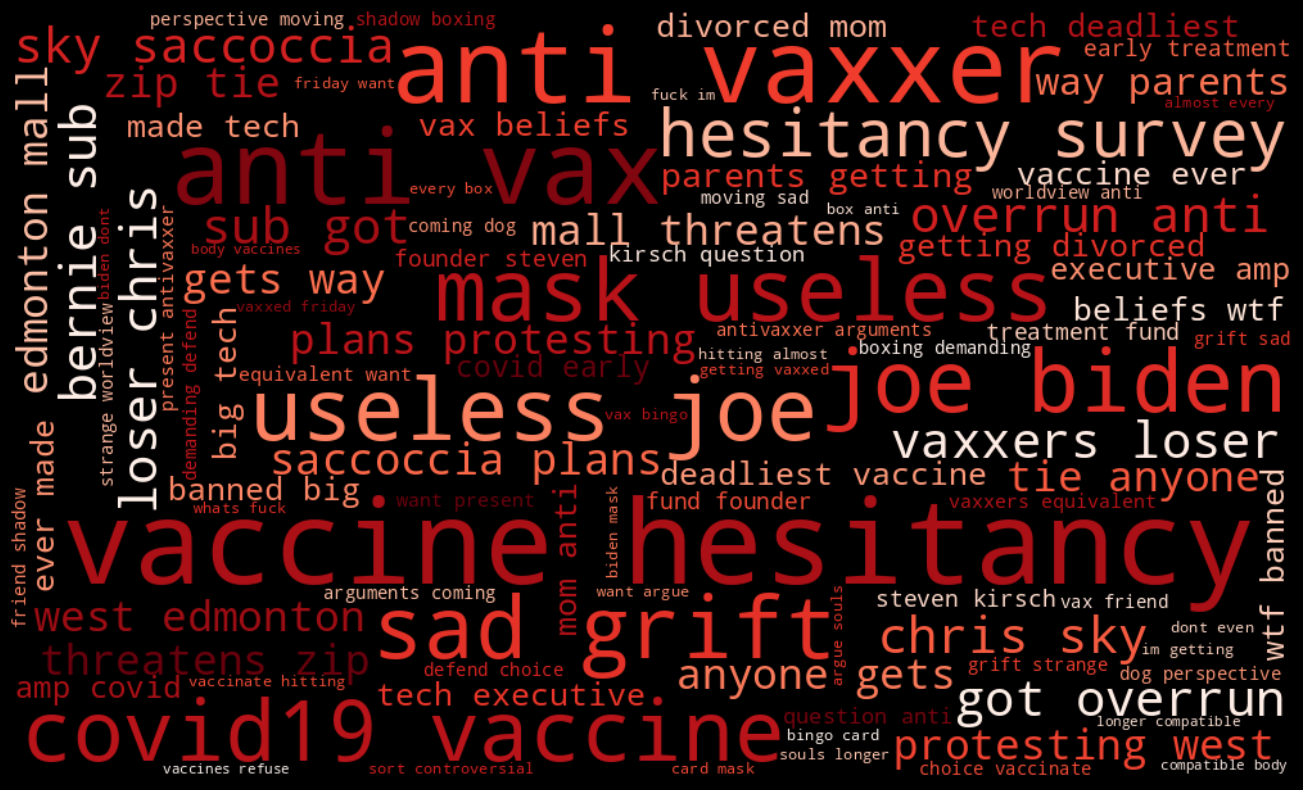

In [ ]:
custom_stopwords = ["said","hey","know","need","youre"]
plot_word_cloud(neg_words, "Reds", custom_stopwords)

In [ ]:
def extract_sentence_from_word(df, word, label, num = 3):
  contains_word = df_merged['title'].str.contains(r"\b{}\b".format(word), case=False) # matches the word only
  label_type = df_merged['label'] == label
  sent_list = df_merged.loc[contains_word & label_type].title.values
  print("\n".join(sent for sent in sent_list[:num]))

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
extract_sentence_from_word(df_merged, "anti", "neg", num = 5)

Bernie sub got overrun by anti vaxxers
Parents are getting divorced over mom’s anti vax beliefs
Question for Anti Vaxxers: Is there an equivalent?
Anti vax friend is shadow boxing and demanding I defend my choice to vaccinate. He’s hitting almost every box in my anti vax bingo card.
I meting t my 1st anti vaxx today, I’ll be calling him av for anti Vaxxer, I’m pv, for pro vaxxer, here’s some of the stuff he says: why would injecting poison in your are give you super powers? (He doesn’t know how vaccines work) he don’t let you talk, swears at you, and calls it a fake.


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Dynamic Topic Modelling

Dynamic topic modeling (DTM) is an extension of Latent Dirichlet Allocation (LDA), a probabilistic topic modeling technique, that models the evolution of topics over time. In contrast to standard LDA, which assumes that topics are static and present across the entire corpus, DTM takes into account the temporal dimension of the data and allows for topics to change and evolve over time. This makes DTM well-suited for analyzing datasets where the distribution of topics varies over time, such as in social media, news articles, or scientific literature. In DTM, each time slice of the corpus is modeled as a separate LDA model, and the evolution of topics between time slices is captured using a Markov process. The output of DTM is a sequence of topic models, one for each time slice, that captures the changing distribution of topics over time.

Create a document-term matrix: Convert the preprocessed text data into a document-term matrix, where each row represents a document and each column represents a term.

Prepare the data for dynamic topic modeling: Convert the document-term matrix into a corpus, where each element in the corpus represents a document as a bag of words. You can use the Gensim library for this.

Train the dynamic topic model: Train a dynamic topic model on the corpus, where the number of topics and the number of time periods can be specified. You can use the DtmModel class from the Gensim library for this.

Visualize the topics: Visualize the topics over time using a heatmap, where each row represents a topic and each column represents a time period. You can use the seaborn library for this.

Analyze the topics: Analyze the topics over time to identify any trends, patterns, or changes in the topics.

In [ ]:
df = pd.read_excel("AntiVaxxers_January2021.xlsx")

In [ ]:
df['created_utc'].unique()

array(['2021-11-30T22:53:46.000000000', '2021-11-30T22:41:15.000000000',
       '2021-11-30T22:01:04.000000000', '2021-11-30T17:14:57.000000000',
       '2021-11-30T13:54:38.000000000', '2021-11-30T08:48:00.000000000',
       '2021-11-30T07:24:25.000000000', '2021-11-30T02:00:07.000000000',
       '2021-11-30T00:18:12.000000000', '2021-11-29T23:49:56.000000000',
       '2021-11-29T21:26:01.000000000', '2021-11-29T19:32:06.000000000',
       '2021-11-29T17:53:15.000000000', '2021-11-29T17:50:35.000000000',
       '2021-11-29T17:16:04.000000000', '2021-11-29T13:56:52.000000000',
       '2021-11-29T12:31:36.000000000', '2021-11-29T11:23:19.000000000',
       '2021-11-29T10:57:03.000000000', '2021-11-29T10:34:57.000000000',
       '2021-11-29T08:39:52.000000000', '2021-11-29T07:43:21.000000000',
       '2021-11-29T06:23:33.000000000', '2021-11-29T06:13:24.000000000',
       '2021-11-29T05:06:28.000000000', '2021-11-29T04:50:38.000000000',
       '2021-11-29T04:46:06.000000000', '2021-11-29

In [ ]:
import gensim
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import string
import re

# load stop words and stemmer
nltk.download('stopwords')
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

# define preprocessing function
def preprocess_text(text):
    # remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # convert to lower case
    text = text.lower()
    # tokenize text
    words = gensim.utils.simple_preprocess(text)
    # remove stop words
    words = [word for word in words if word not in stop_words]
    # stem words
    words = [stemmer.stem(word) for word in words]
    return words

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# preprocess text data
df['processed_text'] = df['title'].apply(preprocess_text)

In [ ]:
# Convert 'created_utc' column to datetime format
df['created_utc'] = pd.to_datetime(df['created_utc'], unit='s')


1.   gensim is a Python library for topic modeling, document indexing, and similarity retrieval with large corpora. It provides a simple interface for creating and training topic models using Latent Dirichlet Allocation (LDA) and other algorithms.

2.   LdaModel is a class in the gensim library that implements the Latent Dirichlet Allocation (LDA) topic modeling algorithm. It can be used to create and train an LDA model on a corpus of text documents.

3. CoherenceModel is another class in the gensim library that is used to compute the coherence score of a topic model. Coherence is a measure of how interpretable and distinct the topics are in a topic model.





This code is creating a dictionary and a bag-of-words corpus from the pre-processed text data in df['processed_text'].

The Dictionary function from the gensim library creates a dictionary that maps each word to a unique id. The doc2bow function then converts each document in the corpus (in this case, each element of df['processed_text']) into a bag-of-words representation, where each word in the document is replaced with its corresponding id in the dictionary, and the count of each word is recorded.

This is a necessary step in topic modeling, as most topic modeling algorithms require a numerical representation of the text data in the form of a bag-of-words matrix.

In [ ]:
# Create dictionary and corpus
from gensim.corpora import Dictionary
dictionary = Dictionary(df['processed_text'])
corpus = [dictionary.doc2bow(text) for text in df['processed_text']]

In [ ]:
# Set parameters for LDA model
from gensim.models import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.corpus import stopwords
import os

num_topics = 5
passes = 10
iterations = 100
eval_every = None

# Build LDA model
lda_model = LdaModel(corpus=corpus,
                     id2word=dictionary,
                     num_topics=num_topics,
                     passes=passes,
                     iterations=iterations,
                     eval_every=eval_every)

In [ ]:
# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model, 
                                     texts=df['processed_text'], 
                                     dictionary=dictionary, 
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()

# Print coherence score
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4951549233212251


In [ ]:
# Create folder to store monthly topic models
if not os.path.exists('monthly_topic_models'):
    os.makedirs('monthly_topic_models')

In [ ]:
df.dtypes

author                    object
created_utc       datetime64[ns]
domain                    object
id                        object
num_comments               int64
score                      int64
title                     object
url                       object
processed_text            object
dtype: object

In [ ]:
# Save monthly topic models to separate files
for idx, month in enumerate(df['created_utc'].dt.to_period('M').unique()):
    month_str = month.strftime('%Y_%m')
    filename = f'monthly_topic_models/topic_model_{month_str}.model'
    
    year_str = month.strftime('%Y')
    # Create folder for year if it doesn't exist
    year_folder = os.path.join('monthly_topic_models',year_str )
    if not os.path.exists(year_folder):
        os.makedirs(year_folder)
    
    # Get corpus slice for month
    data = df.loc[df['created_utc'].dt.to_period('M')==month, 'processed_text']
    dictionary = Dictionary(data)
    month_corpus = [dictionary.doc2bow(doc) for doc in data]
    
    # Build LDA model for month
    month_model = LdaModel(corpus=month_corpus,
                          id2word=dictionary,
                          num_topics=num_topics,
                          passes=passes,
                          iterations=iterations,
                          eval_every=eval_every)
    
    # Save LDA model for month
    month_model.save(filename)
